## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
colours = ['blue', 'red', 'gray', 'black']
import copy
from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

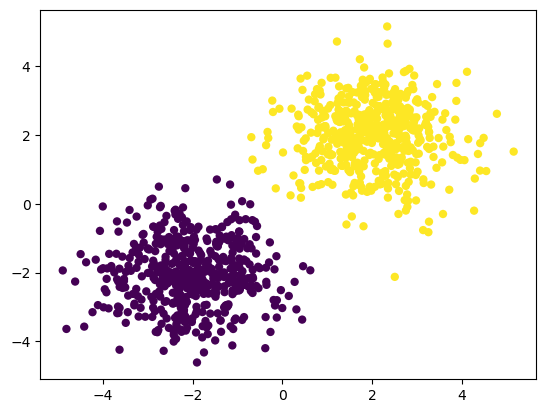

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [43]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [44]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [45]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

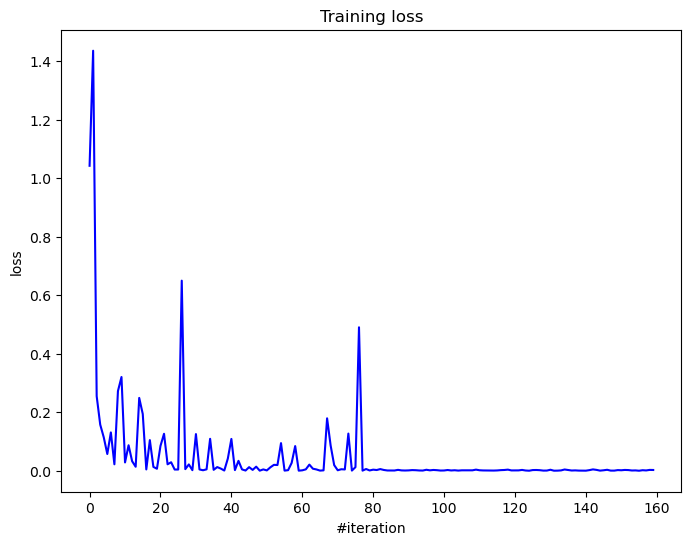

Current loss: 0.002564


In [46]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        print(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype = float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:, 0]] = 1.
    return y_one_hot
def one_hot_decode(y_one_hot):
    return y_one_hot.argmax(axis = 1)[:, None]

n_classes = len(np.unique(y_test))
input_dim = X_train[0].shape[0] * X_train[0].shape[1] * 1
print("Input dim is: ", input_dim)
print("We have {} classes over here".format(n_classes))
y_train_one_hot = one_hot_encode(n_classes, y_train[:, None])
y_test_one_hot = one_hot_encode(n_classes, y_test[:, None])

Input dim is:  784
We have 10 classes over here


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [50]:

net_config = {
    "input_dim": input_dim,
    "hidden_dim": 128,
    "n_layers": 3,
    "use_batchnorm": False,
    "n_classes": 10,
    "dropout_rate": 0.3,
    "weight_decay": 0.}
#training details
batch_size = 128
# ------------------------------

# function, not class, sorry -- creates us net with given configuration
def create_net(config = net_config, activation = 'ReLU',
               param = {"alpha": .9, 'slope': 0.5}):

    activations = {"ReLU": ReLU(),
        "ELU": ELU(alpha = param['alpha']),
        "LeakyReLU": LeakyReLU(slope = param['slope']),
        "SoftPlus": SoftPlus()}

    if activation not in activations:
        raise ValueError("No such activation: choose between" + str(list(activations.keys())))
    else:
        Activation = activations[activation]

    net = Sequential()
    hidden_dim = copy.copy(config["hidden_dim"])
    prev_layer_input_dim = copy.copy(config['input_dim'])

    for layer in range(config["n_layers"]):
        net.add(Linear(prev_layer_input_dim, hidden_dim))


        if (config['use_batchnorm']):
            net.add(BatchNormalization(0.9))
            net.add(ChannelwiseScaling(hidden_dim))
        #net.add(Dropout(p = config["dropout_rate"]))
        net.add(Activation)
        prev_layer_input_dim = hidden_dim

    net.add(Linear(prev_layer_input_dim, config["n_classes"]))
    net.add(SoftMax())
    return net

def evaluate(net, X_train, y_train, X_val, y_val, X_test, y_test, n_epochs: int, batch_size: int,
                    loss_fn, optimizer, plot_args):
    #optimizers configuration
    adam_config = {'learning_rate': .8 * 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
    sgd_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

    # train loop
    def train_model(net, X_train, y_train, X_val, y_val, n_epochs: int, batch_size: int,
                    loss_fn, optimizer, debug = False):
        train_loss_history = []
        val_loss_history = []
        val_accuracy = []
        optimizers = {"SGD": sgd_momentum,
                     "Adam": adam_optimizer}

        if optimizer not in optimizers:
            raise ValueError("No such optimizer: choose between" + str(list(optimizers.keys())))
        else:
            optimizer_ = optimizers[optimizer]
            if optimizer == "Adam": optimizer_config = adam_config
            if optimizer == "SGD": optimizer_config = sgd_config

        optimizer_state = {}

        for epoch in tqdm(range(n_epochs), total = n_epochs):
            ep_train_loss_history = []
            ep_val_loss_history = []
            ep_val_accuracy = []
            start_time = time()

            _ = net.train()
            for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()

                predictions = net.forward(X_batch.reshape((-1, input_dim)))
                loss = loss_fn.forward(predictions, y_batch)
                + .5 * net_config['weight_decay'] * np.sum([np.sum(np.array(p) ** 2) for p in
                                                           np.array(net.getParameters()[0][0])])


                dL = loss_fn.backward(predictions, y_batch) \
                                    + net_config['weight_decay'] * np.sum([np.sum(p) for p in
                                                                    net.getParameters()[0][0]])
                net.backward(X_batch.reshape((-1, input_dim)), dL)

                optimizer_(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

                ep_train_loss_history.append(loss)
                #print(loss)

            _ = net.evaluate()
            for X_batch, y_batch in get_batches((X_val, y_val), batch_size):

                predictions = net.forward(X_batch.reshape((-1, input_dim)))
                loss = loss_fn.forward(predictions, y_batch) \
                 + .5 * net_config['weight_decay'] * np.sum([np.sum(np.array(p) ** 2) for p in
                                                           np.array(net.getParameters()[0][0])])

                y_pred = one_hot_decode(predictions)
                y_batch = one_hot_decode(y_batch)

                ep_val_loss_history.append(loss)
                ep_val_accuracy.append(np.sum(y_batch == y_pred)/ len(y_batch))

            val_accuracy.append(np.mean(ep_val_accuracy))
            val_loss_history.append(np.mean(ep_val_loss_history))
            train_loss_history.append(np.mean(ep_train_loss_history))

            if debug:
                print("Epoch {} took {} s".format(epoch, round(time() - start_time, 3)))
                print("\t Train loss: ", train_loss_history[-1])
                print("\t Validation loss: ", val_loss_history[-1])
                print("\t Validation accuracy: ", val_accuracy[-1])
            print(loss)
        return train_loss_history, val_loss_history, val_accuracy

    #test loop
    def test_model(net, X_est, y_test, batch_size,
                    loss_fn, optimizer, debug = False):
        loss_history = []
        accuracy = []
        _ = net.evaluate()

        start_time = time()

        for X_batch, y_batch in get_batches((X_test, y_test), batch_size):

            predictions = net.forward(X_batch.reshape((-1, input_dim)))
            loss = loss_fn.forward(predictions, y_batch)

            y_pred = one_hot_decode(predictions)
            y_batch = one_hot_decode(y_batch)

            loss_history.append(loss)
            accuracy.append(np.sum(y_batch == y_pred)/ len(y_batch))

        if debug:
            print("Testing took {} s".format(epoch, round(time() - start_time, 3)))

            print("Loss: ", loss_history)
            print("Accuracy: ", accuracy)
        return np.mean(loss_history), np.mean(accuracy)

    def visualize(history_list, accuracy_list, plot_args):
        label = plot_args['label']
        if 'linewidth' in plot_args: linewidth = plot_args['linewidth']
        else: linewidth = 1

        if 'color' in plot_args:
            color = plot_args['color']
            plt.plot(np.arange(1, n_epochs + 1, 1), history_list, label = label,
                 linewidth = linewidth, color = color)

        else: plt.plot(np.arange(1, n_epochs + 1, 1), history_list, label = label,
                 linewidth = linewidth)

        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.grid(True)
        plt.yscale("log")
        plt.legend(loc = 'best')
        print("Accuracy on test is {} \n".format(round(accuracy, 3)))

    print("---------------------------")
    print("___TRAINING AND VALIDATIND____")

    y_train_one_hot = one_hot_encode(n_classes, y_train[:, None])
    y_val_one_hot = one_hot_encode(n_classes, y_val[:, None])
    y_test_one_hot = one_hot_encode(n_classes, y_test[:, None])

    train_loss_history, val_loss_history, val_accuracy = train_model(net, \
                            X_train, y_train_one_hot, X_val, y_val_one_hot, \
                            n_epochs, batch_size, loss_fn, optimizer)

    print("___TESTING____")
    print("---------------------------")

    test_loss, accuracy = test_model(net, X_test, y_test_one_hot, batch_size,
                                     loss_fn, optimizer)
    _ = visualize(val_loss_history, accuracy, plot_args)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Testing activation func ELU
Linear 784 -> 128
ELU
Linear 128 -> 128
ELU
Linear 128 -> 128
ELU
Linear 128 -> 10
SoftMax

---------------------------
___TRAINING AND VALIDATIND____


 33%|███▎      | 1/3 [00:25<00:51, 25.74s/it]

-0.9363862309311943


 67%|██████▋   | 2/3 [00:48<00:23, 23.84s/it]

-0.9639146106880618


100%|██████████| 3/3 [01:15<00:00, 25.14s/it]

-0.9301352161090237
___TESTING____
---------------------------



/var/folders/2z/kypj7czs0m96d3dnhz5n6j1h0000gn/T/ipykernel_19543/1040510234.py:167: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


Accuracy on test is 0.933 

Testing activation func SoftPlus
Linear 784 -> 128
SoftPlus
Linear 128 -> 128
SoftPlus
Linear 128 -> 128
SoftPlus
Linear 128 -> 10
SoftMax

---------------------------
___TRAINING AND VALIDATIND____


 33%|███▎      | 1/3 [00:27<00:55, 27.62s/it]

-0.43752521150485757


 67%|██████▋   | 2/3 [01:11<00:37, 37.39s/it]

-0.3749671815956044


100%|██████████| 3/3 [01:53<00:00, 37.74s/it]

-0.481867664918319
___TESTING____
---------------------------


Accuracy on test is 0.565 



Text(0.5, 1.0, 'Different activation fucntions')

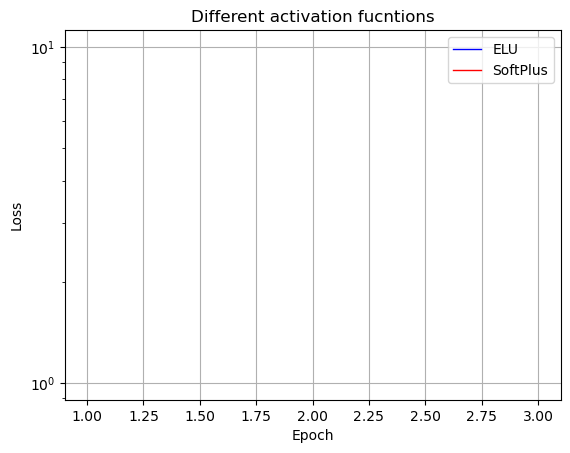

In [54]:
# Your answer goes here. ################################################
%run modules.ipynb
activations = ["ELU", "SoftPlus"]
n_epochs = 3
for i, activation in enumerate(activations):
    print("Testing activation func {}".format(activation))
    Net = create_net(activation = activation)
    print(Net)
    _ = evaluate(Net, X_train, y_train, X_val, y_val, X_test, y_test,
                 n_epochs, batch_size, ClassNLLCriterion(), "Adam",
                 {'label': activation, 'color': colours[i]})

plt.title("Different activation fucntions")

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.